# <center>VAE-baseline for SVHN </center>

## Load Data

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
#Set random seed 
torch.manual_seed(512)

In [6]:
#Get the SVHN train images 
svhn = datasets.SVHN('./data/svhn/', download = True)

In [18]:
#Convert the numpy tensor into a PyTorch one 
x = torch.from_numpy( svhn.data )

In [19]:
#Check characteristics of data 
print(str(type(x)),x.size(), x.min(), x.max())

<class 'torch.Tensor'> torch.Size([73257, 3, 32, 32]) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


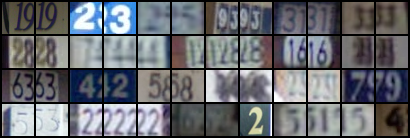

In [22]:
#Check data
check = x.narrow(0,0,48).float().div(255)
title = 'images-svhn-4x12.png'
torchvision.utils.save_image(check,title,nrow=12)
Image(title)

In [21]:
x.size()

torch.Size([73257, 3, 32, 32])

In [23]:
# Organize training data in batches, 
# normalize them to have values between [-1, 1] (?)

train_images = torch.utils.data.DataLoader ( datasets.SVHN('./data/svhn/', download=False,
                               transform=transforms.Compose([
                               #transforms.Resize(64), 
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.ToTensor(),])) , 
                               batch_size = 128, shuffle = True)

In [24]:
for batch_idx, (data,_) in enumerate(train_images):
    print(data.size())
    print(data[0])
    break

torch.Size([128, 3, 32, 32])
tensor([[[ 0.4627,  0.3725,  0.2549,  ...,  0.5373,  0.5412,  0.5451],
         [ 0.4157,  0.3412,  0.2431,  ...,  0.5373,  0.5373,  0.5412],
         [ 0.3765,  0.2863,  0.2314,  ...,  0.5373,  0.5373,  0.5412],
         ...,
         [ 0.5882,  0.5882,  0.5922,  ...,  0.5882,  0.5882,  0.5882],
         [ 0.5922,  0.5922,  0.5961,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.5961,  0.5961,  0.5961,  ...,  0.5961,  0.5961,  0.5961]],

        [[ 0.4000,  0.3020,  0.1961,  ...,  0.5176,  0.5176,  0.5216],
         [ 0.3490,  0.2706,  0.1882,  ...,  0.5176,  0.5176,  0.5216],
         [ 0.3098,  0.2157,  0.1843,  ...,  0.5255,  0.5294,  0.5333],
         ...,
         [ 0.5686,  0.5686,  0.5686,  ...,  0.5686,  0.5686,  0.5686],
         [ 0.5725,  0.5725,  0.5725,  ...,  0.5725,  0.5725,  0.5725],
         [ 0.5765,  0.5765,  0.5725,  ...,  0.5765,  0.5765,  0.5765]],

        [[ 0.3137,  0.2314,  0.1686,  ...,  0.4941,  0.4941,  0.4980],
         [ 0.258

## Model

We will use the arquitecture suggested by [Radford et al](https://arxiv.org/abs/1511.06434) for both the encoder and decoder. With convolutional layers in the encoder and fractionally-strided  convolutions  in  the  decoder.   In  each convolutional layer in the encoder we double the number of filters present in the previous layer and use a convolutional stride of 2.  In each convolutional layer in the decoder we use a fractional stride of 2 and halve the number of filters on each layer.

In [25]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

class VAE( nn.Module ):

    def __init__ ( self, image_size ,  hidden_dim , encoding_dim ):
        
        super( VAE, self ).__init__()
        
        self.encoding_dim = encoding_dim
        self.image_size = image_size
        self.hidden_dim = hidden_dim 
        
        # Decoder - Fractional strided convolutional layers
        self.decoder  = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False),
            nn.Sigmoid() # nn.Tanh()  
        )
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(32, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 0, bias = False),
            nn.Sigmoid()
        )
        
        # Fully-connected layers
        self.fc1 = nn.Linear(256, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc3 = nn.Linear(self.encoding_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, 256)
    
    def decode (self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.sigmoid(self.fc4(h3))
        return self.decoder( h4.view(z.size(0),-1,1,1) ) 

        
    def forward(self, x):
        
        # Encode 
        encoded = F.relu(self.fc1( self.encoder(x).view(x.size(0), -1) ) )
        
        #Obtain mu and logvar
        mu = self.fc21( encoded )
        logvar = self.fc22 ( encoded )
        
        #Reparametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        
        # Decode 
        decoded = self.decode(z)

        # return decoded, mu, logvar
        return decoded, mu , logvar

    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [26]:
#Define model
model = VAE( 32, 100, 20 )
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Train model
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_images):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_images.dataset),
                100. * batch_idx / len(train_images),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_images.dataset)))

In [30]:
num_epochs = 30
for epoch in range(1,num_epochs):
    train(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20)
        sample = model.decode(sample)
        torchvision.utils.save_image(sample.view(64, 3, 32, 32),'sample_svhn_' + str(epoch) + '.png')

Train Epoch: 1 [0/73257 (0%)]	Loss: 1995.089722
Train Epoch: 1 [6400/73257 (9%)]	Loss: 1934.577515
Train Epoch: 1 [12800/73257 (17%)]	Loss: 1952.717651
Train Epoch: 1 [19200/73257 (26%)]	Loss: 1966.059082
Train Epoch: 1 [25600/73257 (35%)]	Loss: 1981.625854
Train Epoch: 1 [32000/73257 (44%)]	Loss: 1938.928833
Train Epoch: 1 [38400/73257 (52%)]	Loss: 1943.335571
Train Epoch: 1 [44800/73257 (61%)]	Loss: 1948.661621
Train Epoch: 1 [51200/73257 (70%)]	Loss: 1934.101562
Train Epoch: 1 [57600/73257 (79%)]	Loss: 1927.485840
Train Epoch: 1 [64000/73257 (87%)]	Loss: 1934.361450
Train Epoch: 1 [70400/73257 (96%)]	Loss: 1932.516846
====> Epoch: 1 Average loss: 1948.7969
Train Epoch: 2 [0/73257 (0%)]	Loss: 1935.699219
Train Epoch: 2 [6400/73257 (9%)]	Loss: 1947.851440
Train Epoch: 2 [12800/73257 (17%)]	Loss: 1930.078857
Train Epoch: 2 [19200/73257 (26%)]	Loss: 1893.420532
Train Epoch: 2 [25600/73257 (35%)]	Loss: 1914.004883
Train Epoch: 2 [32000/73257 (44%)]	Loss: 1954.980225
Train Epoch: 2 [38400

Train Epoch: 13 [19200/73257 (26%)]	Loss: 1935.198242
Train Epoch: 13 [25600/73257 (35%)]	Loss: 1903.846436
Train Epoch: 13 [32000/73257 (44%)]	Loss: 1914.655396
Train Epoch: 13 [38400/73257 (52%)]	Loss: 1945.909790
Train Epoch: 13 [44800/73257 (61%)]	Loss: 1933.011230
Train Epoch: 13 [51200/73257 (70%)]	Loss: 1916.063110
Train Epoch: 13 [57600/73257 (79%)]	Loss: 1909.608154
Train Epoch: 13 [64000/73257 (87%)]	Loss: 1898.688965
Train Epoch: 13 [70400/73257 (96%)]	Loss: 1911.343750
====> Epoch: 13 Average loss: 1927.4748
Train Epoch: 14 [0/73257 (0%)]	Loss: 1938.339478
Train Epoch: 14 [6400/73257 (9%)]	Loss: 1925.381714
Train Epoch: 14 [12800/73257 (17%)]	Loss: 1976.832886
Train Epoch: 14 [19200/73257 (26%)]	Loss: 1929.930054
Train Epoch: 14 [25600/73257 (35%)]	Loss: 1928.129883
Train Epoch: 14 [32000/73257 (44%)]	Loss: 1926.516113
Train Epoch: 14 [38400/73257 (52%)]	Loss: 1910.325439
Train Epoch: 14 [44800/73257 (61%)]	Loss: 1931.741943
Train Epoch: 14 [51200/73257 (70%)]	Loss: 1884.61

Train Epoch: 25 [25600/73257 (35%)]	Loss: 1886.562866
Train Epoch: 25 [32000/73257 (44%)]	Loss: 1948.261719
Train Epoch: 25 [38400/73257 (52%)]	Loss: 1928.464600
Train Epoch: 25 [44800/73257 (61%)]	Loss: 1884.952637
Train Epoch: 25 [51200/73257 (70%)]	Loss: 1956.340332
Train Epoch: 25 [57600/73257 (79%)]	Loss: 1909.225830
Train Epoch: 25 [64000/73257 (87%)]	Loss: 1957.656006
Train Epoch: 25 [70400/73257 (96%)]	Loss: 1920.303101
====> Epoch: 25 Average loss: 1923.1355
Train Epoch: 26 [0/73257 (0%)]	Loss: 1918.038940
Train Epoch: 26 [6400/73257 (9%)]	Loss: 1926.341187
Train Epoch: 26 [12800/73257 (17%)]	Loss: 1930.715942
Train Epoch: 26 [19200/73257 (26%)]	Loss: 1914.600708
Train Epoch: 26 [25600/73257 (35%)]	Loss: 1941.457397
Train Epoch: 26 [32000/73257 (44%)]	Loss: 1924.797363
Train Epoch: 26 [38400/73257 (52%)]	Loss: 1918.322388
Train Epoch: 26 [44800/73257 (61%)]	Loss: 1935.302490
Train Epoch: 26 [51200/73257 (70%)]	Loss: 1910.110352
Train Epoch: 26 [57600/73257 (79%)]	Loss: 1930.14